In [1]:
%%capture
%%bash
pip install torchdiffeq

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchdiffeq import odeint
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.utils.data import Dataset, DataLoader

import numpy as np

import random

import warnings
import datetime

from copy import deepcopy

import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
class OscillatorsDataset(Dataset):
    """
    Dampled Coupled Oscillators synthetic dataset.
    
    Produces data for the system
    
    |-spring-mass-spring-mass-spring-| w/ 'air' resistance
    
    where | are walls (i.e. immovable boundaries), described by
    
    f_i = k*(x_j - 2*x_i) - c*v_i
    
    for force f, displacements x, and velocity v, using Euler integration.
    
    Parameters
        n       : int, number of samples
        dt      : float, time step
        freq    : int, how frequently to sample (multiple of dt)
        samples : int, how many samples to take (multiples of freq)
                  (an extra sample is include for t=0)
    (possible) sampling parameters
        m1,m2   : masses
        x1,x2   : initial positions
        v1,v2   : initial velocities
        k       : (ideal) spring constant
        c       : 'air' resistance constant
    If a float is provided for a sampling parameter, it is fixed at that value;
    if a list is provided, it will be uniformly sampled from the range.

    The time step, freq and samples default to
        dt      : 0.01
        freq    : 10
        samples : 10
    n defaults to 1.
    
    The 'inputs' are the sampled parameters, i.e. if only the initial
    positions are left unspecified and the 'outputs' are the positions
    over time (x1(t),x2(t)).
    
    Output times are normalised to run 0 to 1, such that the first sample
    is always at time = 0 and the final is always at time = 1.
    """
    
    def __init__(self, config, train=True, verbose=True):

        # from config
        #   base simulator setup
        self.dt = config['simulator']['dt']
        self.freq = config['simulator']['sampling_freq']
        self.samples = config['simulator']['samples']
        #   system parameter dictionaries
        self.fixed = config['fixed']
        if train:
            self.varying = config['varying']
            self.n = config['train_examples']
        else:
            self.varying = config['eval_varying']
            self.n = config['eval_examples']
        
        # + 1 for the extra sample at t = 0
        self.total_steps = self.freq*self.samples + 1
        # normalised times
        self.times = torch.arange(0,self.samples+1,1)/(1.*self.samples)
        
        if verbose:
            if train:
                print('Training data generation...')
            else:
                print('Evaluation data generation...')
            print('Fixed paramters', self.fixed)
            print('Varying parameters', self.varying)
        
        self.data = []
        # generate data
        for _ in range(self.n):
            description, conditions = self.description_and_conditions()
            output = self.single_run(conditions)
            self.data.append((description, output, self.times))
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.n
    
    def description_and_conditions(self):
        """
        Return a sample of initial conditions, with those specified at
        input being fixed and the unspecified being the description, too.
        """
        
        conditions = deepcopy(self.fixed)
        for key in self.varying:
            if key in conditions:
                warnings.warn('System parameter defined in both fixed and varying configs')
            low = min(self.varying[key])
            high = max(self.varying[key])
            conditions[key] = np.random.uniform(low,high)
        
        # the description is the varying part
        description = [conditions[v] for v in self.varying]
        
        return torch.FloatTensor(description), conditions
    
    def single_run(self, conditions):
        x1, x2 = conditions['x1'], conditions['x2']
        v1, v2 = conditions['v1'], conditions['v2']
        m1, m2 = conditions['m1'], conditions['m2']
        c, k = conditions['c'], conditions['k']
        output = []
        for step in range(self.total_steps):
            if step % self.freq == 0:
                output.append([x1,x2,v1,v2])          #Can get rid of v1 and v2 here if I don't care about velocity.
            
            a1 = k*(x2-2*x1) - c*v1
            a2 = k*(x1-2*x2) - c*v2
            
            x1 += self.dt*v1
            x2 += self.dt*v2
            v1 += self.dt*a1
            v2 += self.dt*a2
    
        return torch.FloatTensor(output)

In [ ]:
config = {
    # data stuff
    'train_examples' : 500,
    'train_val_split' : 0.8,
    'eval_examples' : 100,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 20,
        'samples' : 50
    },
    'fixed' : {
        'm1' : 1,
        'm2' : 1,
        'x1' : 1,
        'x2' : -1,
        'v1' : 0,
        'v2' : 0,
        'c' : 1
    },
    'varying' : {
        'k' : [0.2, 1.]
    },
    'eval_varying' : {
        'k' : [0.2, 1.]
    }
}

In [ ]:
osc = OscillatorsDataset(config)

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}


In [ ]:
# datasets
train_val_set = OscillatorsDataset(config)
train_set = train_val_set[:int(config['train_examples']*config['train_val_split'])]
val_set = train_val_set[int(config['train_examples']*config['train_val_split']):]
eval_set = OscillatorsDataset(config, train=False)

train_examples = len(train_set)
val_examples = len(val_set)
eval_examples = len(eval_set)

# loaders
train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(val_set, batch_size=1)
eval_loader = DataLoader(eval_set, batch_size=1)

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}
Evaluation data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'x1': 1, 'x2': -1, 'v1': 0, 'v2': 0, 'c': 1}
Varying parameters {'k': [0.2, 1.0]}


In [ ]:
i = 0
for inputs, labels, times in train_loader:
  if i == 0:
    print(labels)
  i+=1

tensor([[[ 1.0000e+00, -1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 9.6841e-01, -9.6841e-01, -3.1941e-01,  3.1941e-01],
         [ 8.8024e-01, -8.8024e-01, -5.6108e-01,  5.6108e-01],
         [ 7.5131e-01, -7.5131e-01, -7.2338e-01,  7.2338e-01],
         [ 5.9719e-01, -5.9719e-01, -8.1013e-01,  8.1013e-01],
         [ 4.3230e-01, -4.3230e-01, -8.2927e-01,  8.2927e-01],
         [ 2.6918e-01, -2.6918e-01, -7.9169e-01,  7.9169e-01],
         [ 1.1798e-01, -1.1798e-01, -7.0996e-01,  7.0996e-01],
         [-1.3710e-02,  1.3710e-02, -5.9725e-01,  5.9725e-01],
         [-1.2093e-01,  1.2093e-01, -4.6636e-01,  4.6636e-01],
         [-2.0116e-01,  2.0116e-01, -3.2894e-01,  3.2894e-01],
         [-2.5410e-01,  2.5410e-01, -1.9501e-01,  1.9501e-01],
         [-2.8122e-01,  2.8122e-01, -7.2536e-02,  7.2536e-02],
         [-2.8541e-01,  2.8541e-01,  3.2654e-02, -3.2654e-02],
         [-2.7051e-01,  2.7051e-01,  1.1690e-01, -1.1690e-01],
         [-2.4089e-01,  2.4089e-01,  1.7854e-01, -1.785

In [ ]:
# sanity plot
save = False

f = plt.figure()

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Trajectories found by sampling over the spring constant, $k$')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')

if save: 
  f.savefig('varying_k_trajectories.pdf', bbox_inches='tight')

plt.show()

In [4]:
config_2 = {
    # data stuff
    'train_examples' : 500,
    'train_val_split' : 0.8,
    'eval_examples' : 100,
    'simulator' : {
        'dt' : 0.01,
        'sampling_freq' : 20,
        'samples' : 50
    },
    'fixed' : {
        'm1' : 1,
        'm2' : 1,
        'v1' : 0,
        'v2' : 0,
        'x2' : 0,
        'k' : 1,
        'c' : 1
    },
    'varying' : {
        'x1' : [-1., 1.]
    },
    'eval_varying' : {
        'x1' : [-1., 1.]
    }
}

In [5]:
osc_2 = OscillatorsDataset(config_2)

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'v1': 0, 'v2': 0, 'x2': 0, 'k': 1, 'c': 1}
Varying parameters {'x1': [-1.0, 1.0]}


In [6]:
# datasets
train_val_set = OscillatorsDataset(config_2)
train_set = train_val_set[:int(config_2['train_examples']*config_2['train_val_split'])]
val_set = train_val_set[int(config_2['train_examples']*config_2['train_val_split']):]
eval_set = OscillatorsDataset(config_2, train=False)

train_examples = len(train_set)
val_examples = len(val_set)
eval_examples = len(eval_set)

# loaders
train_loader = DataLoader(train_set, batch_size=1)
val_loader = DataLoader(val_set, batch_size=1)
eval_loader = DataLoader(eval_set, batch_size=1)

Training data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'v1': 0, 'v2': 0, 'x2': 0, 'k': 1, 'c': 1}
Varying parameters {'x1': [-1.0, 1.0]}
Evaluation data generation...
Fixed paramters {'m1': 1, 'm2': 1, 'v1': 0, 'v2': 0, 'x2': 0, 'k': 1, 'c': 1}
Varying parameters {'x1': [-1.0, 1.0]}


In [9]:
torch.save(train_loader, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/train_loader.pt')
torch.save(val_loader, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/val_loader.pt')
torch.save(eval_loader, '/content/drive/MyDrive/colab_notebooks/NODE_Hessian/damped_oscillators/experiment_0/data/eval_loader.pt')

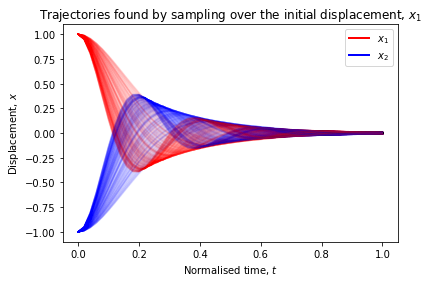

In [ ]:
# sanity plot
save = False

f = plt.figure()

for inputs, labels, times in train_loader:
    plt.plot(times[0], labels[0,:,0], alpha=0.03, c='r')
    plt.plot(times[0], labels[0,:,1], alpha=0.03, c='b')
plt.title('Trajectories found by sampling over the initial displacement, $x_1$')
custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='b', lw=2)]
plt.legend(custom_lines, ['$x_1$', '$x_2$'])
plt.xlabel('Normalised time, $t$')
plt.ylabel('Displacement, $x$')

if save: 
  f.savefig('varying_x_trajectories.pdf', bbox_inches='tight')

plt.show()